In [1]:
import pyspark
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score

sc = pyspark.SparkContext(appName="BigDataProject")

sc

<SparkContext master=local[*] appName=BigDataProject>

In [2]:
#sc.stop()

In [2]:
import variables
#List of english function words
function_words = variables.function_words

#List of punctuations char
punctuations_char = variables.punctuations_char

#Dataset path
my_dir = "./BooksDataset"

# False if you don't have the rdd saved, True otherwise
readFromSavedFile = True

#List of Authors
authors = variables.authors

#Number of Authors
n_authors = len(authors)

In [3]:
#Save/read all books' name of every author

if not readFromSavedFile:
    for i in range(n_authors):
        book = []
        mydiraut = my_dir+"/"+authors[i]
        print(f"Getting books' name for author: {authors[i]}")
        
        for file in os.listdir(mydiraut):
            d = os.path.join(mydiraut, file)
            book.append(file)
            
        print(f"Start - Saving RDD of all books' name of author: {authors[i]}")
        sc.parallelize(book).saveAsTextFile("./RDD/BooksName/"+authors[i])
        print(f"End - Saving RDD of all books' name of author: {authors[i]}\n")
    

booksName = []

for i in range(n_authors):
    print(f" Start - Reading all books' name from saved RDD of author: {authors[i]}")
    booksName.append(sc.textFile("./RDD/BooksName/" + authors[i] + "/*").collect()) 
    print(f" End - Reading all books' name from saved RDD of author: {authors[i]}")
    


 Start - Reading all books' name from saved RDD of author: Bret Harte
 End - Reading all books' name from saved RDD of author: Bret Harte
 Start - Reading all books' name from saved RDD of author: Charles Dickens
 End - Reading all books' name from saved RDD of author: Charles Dickens
 Start - Reading all books' name from saved RDD of author: Daniel Defoe
 End - Reading all books' name from saved RDD of author: Daniel Defoe
 Start - Reading all books' name from saved RDD of author: Edith Wharton
 End - Reading all books' name from saved RDD of author: Edith Wharton
 Start - Reading all books' name from saved RDD of author: Jane Austen
 End - Reading all books' name from saved RDD of author: Jane Austen
 Start - Reading all books' name from saved RDD of author: Joseph Conrad
 End - Reading all books' name from saved RDD of author: Joseph Conrad
 Start - Reading all books' name from saved RDD of author: Lewis Carroll
 End - Reading all books' name from saved RDD of author: Lewis Carroll


In [4]:
#Function to clear the text given in input

def clearText(file_path):
    return sc.textFile(file_path).filter(bool)  \
                .map(lambda w: w.replace("."," . ")) \
                .map(lambda w: w.replace(","," , ")) \
                .map(lambda w: w.replace(";"," ; ")) \
                .map(lambda w: w.replace(":"," : ")) \
                .map(lambda w: w.replace("!"," ! ")) \
                .map(lambda w: w.replace("?"," ? ")) \
                .map(lambda w: w.replace('"',' " ')) \
                .map(lambda w: w.replace("”"," ” ")) \
                .map(lambda w: w.replace("“"," “ ")) \
                .map(lambda w: w.replace("’"," ’ ")) \
                .map(lambda w: w.replace("‘"," ‘ ")) \
                .map(lambda w: w.replace("-"," - ")) \
                .map(lambda w: w.replace("_"," _ ")) \
                .map(lambda w: w.replace("{"," { ")) \
                .map(lambda w: w.replace("}"," } ")) \
                .map(lambda w: w.replace("["," [ ")) \
                .map(lambda w: w.replace("]"," ] ")) \
                .map(lambda w: w.replace("("," ( ")) \
                .map(lambda w: w.replace(")"," ) ")) \
                .map(lambda w: w.replace("*"," * "))


In [6]:
#WordCount returning a list of words

def wordCount(file_path):
    words = clearText(file_path) \
                .flatMap(lambda line: line.split(" ")) \
                .map(lambda w: w.lower()) \
                .map(lambda w: (w, 1)) \
                .reduceByKey(lambda v1, v2: v1 + v2) \
                .filter(lambda w: w[0] != "") \
                .sortBy(lambda w: -w[1])
    
    result = words.collect()

    # Calculate total words of the book given in input
    total_words = 0
    for t in result:
        if t[0] not in punctuations_char:
            total_words += t[1]
            
    # Add the total word to the list of words
    result.append(('total_words', total_words))  
    
    return sc.parallelize(result)

In [7]:
#Saving word count RDD for every book for all authors

if not readFromSavedFile:

    for i in range(n_authors): #n_authors
        # Obtain the path of author directory
        tmp_filename = os.path.join(my_dir, authors[i])
        print(f"Word count of {authors[i]}'s books.")
        
        for j in range(len(booksName[i])): #len(booksName[i])
            # Obtain the path of books given the path of an author
            input_filename = os.path.join(tmp_filename, booksName[i][j])
            
            print(f"Start - Word count of book: {booksName[i][j]}")
            wordsOfABook = wordCount(input_filename)
            print(f"End - Word count of book: {booksName[i][j]}\n")
            
            print(f"Start - Saving word count of book: {booksName[i][j]}")
            wordsOfABook.saveAsTextFile("./RDD/Books/SingleBooks/"+ authors[i] + "/" + booksName[i][j])
            print(f"End - Saving word count of book: {booksName[i][j]}\n")
            
        

In [8]:
#Given a list of string convert it to a list of tuple
def stringToTuple(wordCount):

    result = []
    for s in wordCount:
        #Remove useless characters in the string
        res = s.strip("(").strip(")").split(", ")   
        tmp = len(res[0])
        #Take only the string inside the ''
        result.append((str(res[0][1:tmp-1]), float(res[1])))
        
    return result

In [9]:
#Read saved word count RDD for every book for all authors
wordsCountAuthorsBooks = [[] for _ in range(n_authors)]

for i in range(n_authors):
    print(f"Reading books for: {authors[i]}")
    for j in range(len(booksName[i])):
        # Getting path of books' name RDD
        tmp = "./RDD/Books/SingleBooks/" + authors[i] + "/" + booksName[i][j] + "/*"

        print(f"Start - Reading words count of book: {booksName[i][j]}")
        result = sc.textFile(tmp).collect()
        # Converting list of string into list of tuple
        result = stringToTuple(result)
        print(f"End - Reading words count of book: {booksName[i][j]}\n")

        wordsCountAuthorsBooks[i].append(result)
        

Reading books for: Bret Harte
Start - Reading words count of book: Bret Harte_A First Family of Tasajara.txt
End - Reading words count of book: Bret Harte_A First Family of Tasajara.txt

Start - Reading words count of book: Bret Harte_A Protegee of Jack Hamlin's and Other Stories.txt
End - Reading words count of book: Bret Harte_A Protegee of Jack Hamlin's and Other Stories.txt

Start - Reading words count of book: Bret Harte_A Sappho of Green Springs.txt
End - Reading words count of book: Bret Harte_A Sappho of Green Springs.txt

Start - Reading words count of book: Bret Harte_A Ward of the Golden Gate.txt
End - Reading words count of book: Bret Harte_A Ward of the Golden Gate.txt

Start - Reading words count of book: Bret Harte_By Shore and Sedge.txt
End - Reading words count of book: Bret Harte_By Shore and Sedge.txt

Start - Reading words count of book: Bret Harte_Complete Poetical Works of Bret Harte.txt
End - Reading words count of book: Bret Harte_Complete Poetical Works of Bret

# TRAINING using words NOT in 'function_words' and NOT in 'punctuations_char'

In [10]:
#Calculating Word Count of books in training set for every authors  
training_index = [0, 1, 2, 3, 4, 5, 6]

if not readFromSavedFile:
    for a in range(n_authors):

        print(f"Author: {authors[a]}")
        empty_rdd = sc.emptyRDD()
        #Take only the books in training_index
        for b in training_index: #training_index:
            empty_rdd = empty_rdd.union(sc.parallelize(wordsCountAuthorsBooks[a][b]))
        
        #Word Count of all books in training_index of the author
        print("Start - Word Count of all books in training_index")
        # Filter to remove function words and punctuations char
        result = empty_rdd.reduceByKey(lambda v1, v2: v1 + v2) \
                .filter(lambda w: w[0] not in function_words) \
                .filter(lambda w: w[0] not in punctuations_char) \
                .sortBy(lambda w: -w[1])             
        print("End - Word Count of all books in training_index")
        
        #Take total words of the training set
        total_words = result.take(1)[0][1]
        print(f"Total words: {total_words}")
        
        # Normalization
        print("Start - Normalization of word's frequency")
        result = result.map(lambda x: (x[0], x[1]/total_words))
        print("End - Normalization of word's frequency")
        
        # Only save top 200 words 
        result = sc.parallelize(result.take(200))
        print("Start - Saving RDD Training set")
        result.saveAsTextFile(f"./RDD/Books/TrainingResult/{authors[a]}")
        print("End - Saving RDD Training set\n")    

    
trainingSetWordCountAuthors = []

#Reading RDD of authors training set result
for i in range(n_authors):
    print(f"Author: {authors[i]}")
 
    tmp = f"./RDD/Books/TrainingResult/{authors[i]}/*" 

    print(f"Start - Reading RDD Training set")
    result = sc.textFile(tmp).collect()

    # Converting list of string into list of tuple
    result = stringToTuple(result)
    print(f"End - Reading RDD Training set\n")

    trainingSetWordCountAuthors.append(result)



Author: Bret Harte
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Charles Dickens
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Daniel Defoe
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Edith Wharton
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Jane Austen
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Joseph Conrad
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Lewis Carroll
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Louisa May Alcott
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Voltaire
Start - Reading RDD Training set
End - Reading RDD Training set

Author: William Shakespeare
Start - Reading RDD Training set
End - Reading RDD Training set


In [11]:
def testing(method):
    
    # books of author to test
    testing_index = [7, 8, 9]
    # result of test
    testPredictions = [[] for _ in range(n_authors)] 
    
    # give the predictions for every book in testing index of all authors
    for a in range(n_authors):
        for b in testing_index:
            # word count of the book to test
            bookToTest = wordsCountAuthorsBooks[a][b]
            # take total words of the book
            total_words = bookToTest[len(bookToTest)-1][1] 
            #take only top 100 words
            top100 = []
            count = 0
            # Find the top100 words that are not in 'function_words' and not in 'punctuations_char' + normalization
            for w in bookToTest:
                if (w[0] not in function_words) and (w[0] not in punctuations_char):
                    # Normalization
                    temp = (w[0], w[1]/total_words)
                    top100.append(temp)
                    count += 1
                if count == 100:
                    break
                    
            # predict the author of the book and save the prediction
            if method == 1:
                testPredictions[a].append(method1_words_in_common(top100)) 
            elif method == 2:
                testPredictions[a].append(method2_cosine_similarity(top100, "word_count"))
            elif method == 3:
                testPredictions[a].append(method3_jaccard_similarity(top100))
            
    modelAccuracy = 0
    # Calculate the accuracy of the model
    for a in range(n_authors):
        print(f"\nAuthor: {authors[a]}")
        predictions = testPredictions[a]
        print(predictions)
        
        accuracy = 0
        for p in predictions:
            if method == 1:
                if a in p:
                    accuracy += 1
            else:
                if a == p:
                    accuracy += 1
                
        modelAccuracy += accuracy
        accuracy = accuracy/len(predictions)*100
        print(f"Accuracy to predict the author= {accuracy}%")
        
    # Print the model accuracy
    tot = sum(len(sublist) for sublist in testPredictions)    
    modelAccuracy = modelAccuracy/tot*100
    print(f"\nModel Accuracy= {modelAccuracy}%")
    
    return modelAccuracy/100

# Method 1: Only based on words in common

In [12]:
#Function to count words in common given two lists of tuple. Tuple=(int, 'word')
def count_common_words(list1, list2):
    count_words = 0
    
    list2top100 = list2[1:101]
    
    #count words in common of the 2 lists given in input
    for w in list1:
        for w2 in list2top100:
            if w[0] == w2[0]:
                count_words += 1
                continue
                    
    return count_words


In [13]:
# Predict the author of the book given in input
def method1_words_in_common(top100):
    max_count = -1
    author_index = []
    
    #Check which authors have the greatest number of words in common compared to the book in input
    for a in range(n_authors):
        count = count_common_words(top100,trainingSetWordCountAuthors[a])
        if count == max_count:
            author_index.append(a)
    
        if count > max_count:
            author_index = [a]
            max_count = count 
    
    return author_index

In [14]:
method = 1
accuracy_wordsInCommon = testing(method)


Author: Bret Harte
[[0], [0], [0]]
Accuracy to predict the author= 100.0%

Author: Charles Dickens
[[1], [1], [1]]
Accuracy to predict the author= 100.0%

Author: Daniel Defoe
[[2], [2], [2]]
Accuracy to predict the author= 100.0%

Author: Edith Wharton
[[3], [0], [3]]
Accuracy to predict the author= 66.66666666666666%

Author: Jane Austen
[[4], [4], [4]]
Accuracy to predict the author= 100.0%

Author: Joseph Conrad
[[5], [5], [5]]
Accuracy to predict the author= 100.0%

Author: Lewis Carroll
[[6], [7], [6]]
Accuracy to predict the author= 66.66666666666666%

Author: Louisa May Alcott
[[7], [7], [7]]
Accuracy to predict the author= 100.0%

Author: Voltaire
[[7, 8], [8], [8]]
Accuracy to predict the author= 100.0%

Author: William Shakespeare
[[9], [9], [8]]
Accuracy to predict the author= 66.66666666666666%

Model Accuracy= 90.0%


# Method 2: Using cosine similarity

In [15]:
# Predict the author of the book given in input
def method2_cosine_similarity(list1top100, features):
    
    list1top100Words = [tup[0] for tup in list1top100]
    max_coseno = -1
    author_index = -1
    
    #Check which authors have the greatest number of words in common compared to the book in input
    for a in range(n_authors):
        wordsForCosineSimilarity = []
        for w in list1top100Words:
            wordsForCosineSimilarity.append(w)
        
        if features == "word_count":
            #Take top 100 of training set wordcount
            list2top100 = trainingSetWordCountAuthors[a][1:101]
        elif features == "function-words":
            #Take top 100 of training set FunctionWords
            list2top100 = trainingSetFunctionWordsAuthors[a][1:]
        elif features == "punctuation":
            #Take top 100 of training set Punctuation
            list2top100 = trainingSetPunctuationAuthors[a][1:]
        else:
            print(f"Feature: {features} NOT AVAILABLE")
            list2top100 = []
        
        list2top100Words = [tup[0] for tup in list2top100]
        for w in list2top100Words:
            if w not in wordsForCosineSimilarity:
                wordsForCosineSimilarity.append(w)
        
        wordsValuesList1 = [0 for _ in range(len(wordsForCosineSimilarity))]
        for i, w in enumerate(wordsForCosineSimilarity):
            if w in list1top100Words:
                wordsValuesList1[i] = list1top100[list1top100Words.index(w)][1]
                
        wordsValuesList2 = [0 for _ in range(len(wordsForCosineSimilarity))]
        for i, w in enumerate(wordsForCosineSimilarity):
            if w in list2top100Words:
                wordsValuesList2[i] = list2top100[list2top100Words.index(w)][1]
        
        array_frequenze1 = np.array(wordsValuesList1).reshape(1, -1)
        array_frequenze2 = np.array(wordsValuesList2).reshape(1, -1)
        coseno = cosine_similarity(array_frequenze1, array_frequenze2)
    
        if coseno > max_coseno:
            author_index = a
            max_coseno = coseno 
            
    return author_index

In [16]:
method = 2
accuracy_cosineSimilarity = testing(method)


Author: Bret Harte
[0, 0, 0]
Accuracy to predict the author= 100.0%

Author: Charles Dickens
[7, 1, 1]
Accuracy to predict the author= 66.66666666666666%

Author: Daniel Defoe
[2, 2, 2]
Accuracy to predict the author= 100.0%

Author: Edith Wharton
[3, 3, 3]
Accuracy to predict the author= 100.0%

Author: Jane Austen
[4, 4, 4]
Accuracy to predict the author= 100.0%

Author: Joseph Conrad
[5, 5, 5]
Accuracy to predict the author= 100.0%

Author: Lewis Carroll
[6, 5, 6]
Accuracy to predict the author= 66.66666666666666%

Author: Louisa May Alcott
[7, 7, 7]
Accuracy to predict the author= 100.0%

Author: Voltaire
[8, 8, 8]
Accuracy to predict the author= 100.0%

Author: William Shakespeare
[9, 9, 9]
Accuracy to predict the author= 100.0%

Model Accuracy= 93.33333333333333%


# Method 3: Using Jaccard similarity

In [17]:
# Predict the author of the book given in input
def method3_jaccard_similarity(list1top100):
    
    list1top100Words = set([tup[0] for tup in list1top100])
    max_jaccard = -1
    author_index = -1
    
    #Check which authors have the greatest number of words in common compared to the book in input
    for a in range(n_authors):
        
        #Take top 100 of training set wordcount
        list2top100 = trainingSetWordCountAuthors[a][1:101]
        list2top100Words = set([tup[0] for tup in list2top100])
    
        # Calculate jaccard similarity
        intersection = len(list1top100Words.intersection(list2top100Words))
        union = len(list1top100Words.union(list2top100Words))
        jaccard_similarity = intersection / union

    
        if jaccard_similarity > max_jaccard:
            author_index = a
            max_jaccard = jaccard_similarity 
            
    return author_index

In [18]:
method = 3
accuracy_jaccardSimilarity = testing(method)


Author: Bret Harte
[0, 0, 0]
Accuracy to predict the author= 100.0%

Author: Charles Dickens
[1, 1, 1]
Accuracy to predict the author= 100.0%

Author: Daniel Defoe
[2, 2, 2]
Accuracy to predict the author= 100.0%

Author: Edith Wharton
[3, 0, 3]
Accuracy to predict the author= 66.66666666666666%

Author: Jane Austen
[4, 4, 4]
Accuracy to predict the author= 100.0%

Author: Joseph Conrad
[5, 5, 5]
Accuracy to predict the author= 100.0%

Author: Lewis Carroll
[6, 7, 6]
Accuracy to predict the author= 66.66666666666666%

Author: Louisa May Alcott
[7, 7, 7]
Accuracy to predict the author= 100.0%

Author: Voltaire
[7, 8, 8]
Accuracy to predict the author= 66.66666666666666%

Author: William Shakespeare
[9, 9, 8]
Accuracy to predict the author= 66.66666666666666%

Model Accuracy= 86.66666666666667%


# TRAINING using words ONLY in 'function_words' 

In [19]:
# TRAINING using words ONLY in 'function_words' 
#Calculating Word Count of books in training set for every authors  
training_index = [0, 1, 2, 3, 4, 5, 6]

if not readFromSavedFile:
    for a in range(n_authors):

        print(f"Author: {authors[a]}")
        empty_rdd = sc.emptyRDD()
        #Take only the books in training_index
        for b in training_index: #training_index:
            empty_rdd = empty_rdd.union(sc.parallelize(wordsCountAuthorsBooks[a][b]))
        
        #Word Count of all books in training_index of the author
        print("Start - Word Count of all books in training_index")
        # Filter to take only function words
        result = empty_rdd.reduceByKey(lambda v1, v2: v1 + v2) \
                .filter(lambda w: (w[0] in function_words) or (w[0] == "total_words")) \
                .sortBy(lambda w: -w[1])             
        print("End - Word Count of all books in training_index")
        
        #Take total words of the training set
        total_words = result.take(1)[0][1]
        print(f"Total words: {total_words}")
        
        # Normalization
        print("Start - Normalization of word's frequency")
        result = result.map(lambda x: (x[0], x[1]/total_words))
        print("End - Normalization of word's frequency")
        
        
        print("Start - Saving RDD Training set")
        result.saveAsTextFile(f"./RDD/Books/TrainingFunctionWords/{authors[a]}")
        print("End - Saving RDD Training set\n")    

    
trainingSetFunctionWordsAuthors = []

#Reading RDD of authors training set result
for i in range(n_authors):
    print(f"Author: {authors[i]}")
 
    tmp = f"./RDD/Books/TrainingFunctionWords/{authors[i]}/*" 

    print(f"Start - Reading RDD Training set")
    result = sc.textFile(tmp).collect()

    # Converting list of string into list of tuple
    result = stringToTuple(result)
    print(f"End - Reading RDD Training set\n")

    trainingSetFunctionWordsAuthors.append(result)

Author: Bret Harte
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Charles Dickens
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Daniel Defoe
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Edith Wharton
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Jane Austen
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Joseph Conrad
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Lewis Carroll
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Louisa May Alcott
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Voltaire
Start - Reading RDD Training set
End - Reading RDD Training set

Author: William Shakespeare
Start - Reading RDD Training set
End - Reading RDD Training set


# TRAINING using words ONLY in 'punctuations_char' 

In [20]:
# TRAINING using words ONLY in 'punctuations_char' 
#Calculating Word Count of books in training set for every authors  
training_index = [0, 1, 2, 3, 4, 5, 6]

if not readFromSavedFile:
    for a in range(n_authors):

        print(f"Author: {authors[a]}")
        empty_rdd = sc.emptyRDD()
        #Take only the books in training_index
        for b in training_index: #training_index:
            empty_rdd = empty_rdd.union(sc.parallelize(wordsCountAuthorsBooks[a][b]))
        
        #Word Count of all books in training_index of the author
        print("Start - Word Count of all books in training_index")
        # Filter to take only punctuations_char
        result = empty_rdd.reduceByKey(lambda v1, v2: v1 + v2) \
                .filter(lambda w: (w[0] in punctuations_char) or (w[0] == "total_words")) \
                .sortBy(lambda w: -w[1])             
        print("End - Word Count of all books in training_index")
        
        #Take total words of the training set
        total_words = result.take(1)[0][1]
        print(f"Total words: {total_words}")
        
        # Normalization
        print("Start - Normalization of word's frequency")
        result = result.map(lambda x: (x[0], x[1]/total_words))
        print("End - Normalization of word's frequency")
        
        
        print("Start - Saving RDD Training set")
        result.saveAsTextFile(f"./RDD/Books/TrainingPunctuation/{authors[a]}")
        print("End - Saving RDD Training set\n")    

    
trainingSetPunctuationAuthors = []

#Reading RDD of authors training set result
for i in range(n_authors):
    print(f"Author: {authors[i]}")
 
    tmp = f"./RDD/Books/TrainingPunctuation/{authors[i]}/*" 

    print(f"Start - Reading RDD Training set")
    result = sc.textFile(tmp).collect()

    # Converting list of string into list of tuple
    result = stringToTuple(result)
    print(f"End - Reading RDD Training set\n")

    trainingSetPunctuationAuthors.append(result)

Author: Bret Harte
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Charles Dickens
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Daniel Defoe
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Edith Wharton
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Jane Austen
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Joseph Conrad
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Lewis Carroll
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Louisa May Alcott
Start - Reading RDD Training set
End - Reading RDD Training set

Author: Voltaire
Start - Reading RDD Training set
End - Reading RDD Training set

Author: William Shakespeare
Start - Reading RDD Training set
End - Reading RDD Training set


# Testing 'function_words' or 'punctuations_char' Training set

In [21]:
# Testing function for 'function_words' or 'punctuations_char'
def testing2(features):
    # books of author to test
    testing_index = [7, 8, 9]
    # result of test
    testPredictions = [[] for _ in range(n_authors)] 
    
    # give the predictions for every book in testing index of all authors
    for a in range(n_authors):
        for b in testing_index:
            # word count of the book to test
            bookToTest = wordsCountAuthorsBooks[a][b]
            # take total words of the book
            total_words = bookToTest[len(bookToTest)-1][1] 
            # take words to test
            test = []
            if features == "function-words":
                # Find the words that are in 'function_words'
                for w in bookToTest:
                    if w[0] in function_words:
                        # Normalization
                        temp = (w[0], w[1]/total_words)
                        test.append(temp)                   
            elif features == "punctuation":
                # Find the words that are in 'punctuations_char'
                for w in bookToTest:
                    if w[0] in punctuations_char:
                        # Normalization
                        temp = (w[0], w[1]/total_words)
                        test.append(temp)
            
            # predict the author of the book and save the prediction     
            testPredictions[a].append(method2_cosine_similarity(test, features))
                   
    modelAccuracy = 0
    # Calculate the accuracy of the model
    for a in range(n_authors):
        print(f"\nAuthor: {authors[a]}")
        predictions = testPredictions[a]
        print(predictions)
        
        accuracy = 0
        for p in predictions:
            if a == p:
                accuracy += 1
                
        modelAccuracy += accuracy
        accuracy = accuracy/len(predictions)*100
        print(f"Accuracy to predict the author= {accuracy}%")
        
    # Print the model accuracy
    tot = sum(len(sublist) for sublist in testPredictions)    
    modelAccuracy = modelAccuracy/tot*100
    print(f"\nModel Accuracy= {modelAccuracy}%")
    
    return modelAccuracy/100

In [22]:
accuracy_functionWords = testing2("function-words")


Author: Bret Harte
[0, 0, 0]
Accuracy to predict the author= 100.0%

Author: Charles Dickens
[7, 1, 1]
Accuracy to predict the author= 66.66666666666666%

Author: Daniel Defoe
[8, 2, 1]
Accuracy to predict the author= 33.33333333333333%

Author: Edith Wharton
[3, 8, 3]
Accuracy to predict the author= 66.66666666666666%

Author: Jane Austen
[4, 4, 4]
Accuracy to predict the author= 100.0%

Author: Joseph Conrad
[1, 1, 8]
Accuracy to predict the author= 0.0%

Author: Lewis Carroll
[7, 3, 6]
Accuracy to predict the author= 33.33333333333333%

Author: Louisa May Alcott
[7, 7, 7]
Accuracy to predict the author= 100.0%

Author: Voltaire
[3, 8, 5]
Accuracy to predict the author= 33.33333333333333%

Author: William Shakespeare
[9, 9, 9]
Accuracy to predict the author= 100.0%

Model Accuracy= 63.33333333333333%


In [23]:
accuracy_punctuation = testing2("punctuation")


Author: Bret Harte
[0, 0, 0]
Accuracy to predict the author= 100.0%

Author: Charles Dickens
[0, 1, 4]
Accuracy to predict the author= 33.33333333333333%

Author: Daniel Defoe
[2, 2, 2]
Accuracy to predict the author= 100.0%

Author: Edith Wharton
[0, 3, 5]
Accuracy to predict the author= 33.33333333333333%

Author: Jane Austen
[8, 5, 0]
Accuracy to predict the author= 0.0%

Author: Joseph Conrad
[5, 3, 4]
Accuracy to predict the author= 33.33333333333333%

Author: Lewis Carroll
[6, 0, 6]
Accuracy to predict the author= 66.66666666666666%

Author: Louisa May Alcott
[0, 8, 0]
Accuracy to predict the author= 0.0%

Author: Voltaire
[7, 2, 2]
Accuracy to predict the author= 0.0%

Author: William Shakespeare
[9, 9, 9]
Accuracy to predict the author= 100.0%

Model Accuracy= 46.666666666666664%


# ML Method

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [27]:
#Create authorsBooksForVectorizer array. For every author we store his books text as a string.

authorsBooksForVectorizer = [[] for _ in range(n_authors)]

for a in range(n_authors):
    tmp_filename = os.path.join(my_dir, authors[a])
    for l in range(len(booksName[a])):
        #Create the path of the text of the book
        input_filename = os.path.join(tmp_filename, booksName[a][l])

        #Use pyspark to semplify the text and reduce the rows in a single row string
        text = clearText(input_filename) \
            .map(lambda w: w.lower()) \
            .map(lambda line: " ".join([word for word in line.split() if word not in function_words])) \
            .map(lambda line: " ".join([word for word in line.split() if word not in punctuations_char])) \
            .reduce(lambda x, y: x + " " + y)
            
        #Save text in authorsBooksForVectorizer
        authorsBooksForVectorizer[a].append(text)


In [28]:
#Preparing data for the ML models

#We flat the variable authorsBooksForVectorizer
nested_array = np.array(authorsBooksForVectorizer).flatten()

#Creating author_labels
authors_label = []
for i in range(n_authors):
    for _ in range(n_authors):
        authors_label.append(i)

In [29]:
#TfidfVectorizer  (Term Frequency-Inverse Document Frequency Vectorizer)
#Feature TF-IDF extraction from the text string
vectorizer = CountVectorizer()
#vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(nested_array)

In [30]:
#Convert authors_label in np array
y = np.array(authors_label)

In [31]:
#Split data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [32]:
#Useful variable for the confusion matrix plot
label_mapping = {author: i for i, author in enumerate(authors)}
label_mapping

{'Bret Harte': 0,
 'Charles Dickens': 1,
 'Daniel Defoe': 2,
 'Edith Wharton': 3,
 'Jane Austen': 4,
 'Joseph Conrad': 5,
 'Lewis Carroll': 6,
 'Louisa May Alcott': 7,
 'Voltaire': 8,
 'William Shakespeare': 9}

In [33]:
#choose a classifier_type and calculate the accuracy score
def classifier_function(classifier_type):
    if classifier_type == 'SVC':
        classifier = LinearSVC()
    if classifier_type == 'RandomForest':
        classifier = RandomForestClassifier()
    if classifier_type == 'Bayes':
        classifier = MultinomialNB()

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy score of {classifier_type} : {accuracy}")
    print(f"Classification Report: \n{report}")


    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.xlabel("Valori Predetti")
    plt.ylabel("Valori Veri")
    plt.title("Matrice di Confusione")
    plt.show()

    return accuracy

C:\Users\User\anaconda3\envs\BigData\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy score of SVC : 0.8666666666666667
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       0.50      1.00      0.67         2
           3       1.00      0.75      0.86         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         2
           6       0.33      1.00      0.50         1
           7       1.00      0.80      0.89         5
           8       1.00      0.33      0.50         3
           9       1.00      1.00      1.00         2

    accuracy                           0.87        30
   macro avg       0.88      0.89      0.84        30
weighted avg       0.94      0.87      0.87        30


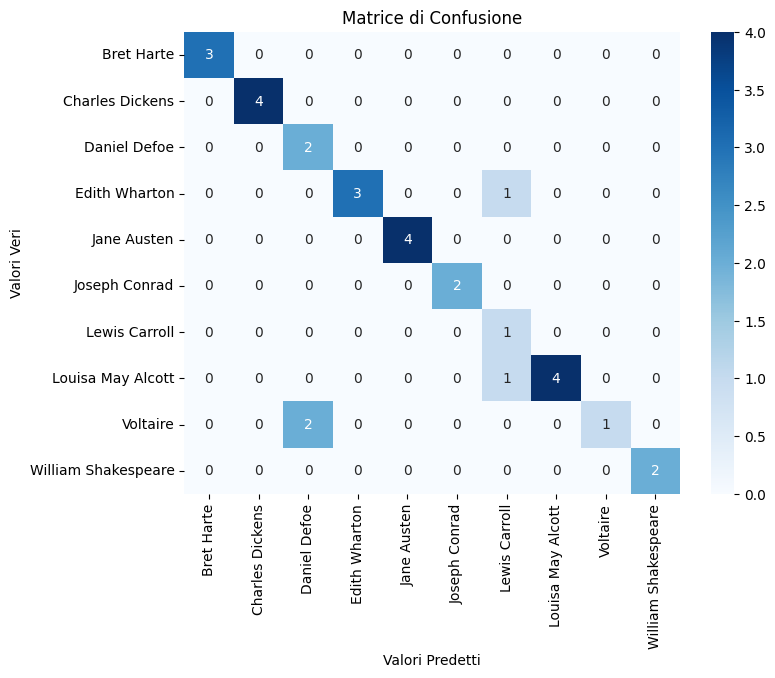

In [34]:
#Linear SVM classifier
accuracy_svc = classifier_function('SVC')

Accuracy score of RandomForest : 0.7666666666666667
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.50      0.67         4
           2       0.50      1.00      0.67         2
           3       1.00      0.50      0.67         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         2
           6       0.17      1.00      0.29         1
           7       1.00      0.80      0.89         5
           8       1.00      0.33      0.50         3
           9       1.00      1.00      1.00         2

    accuracy                           0.77        30
   macro avg       0.87      0.81      0.77        30
weighted avg       0.94      0.77      0.80        30


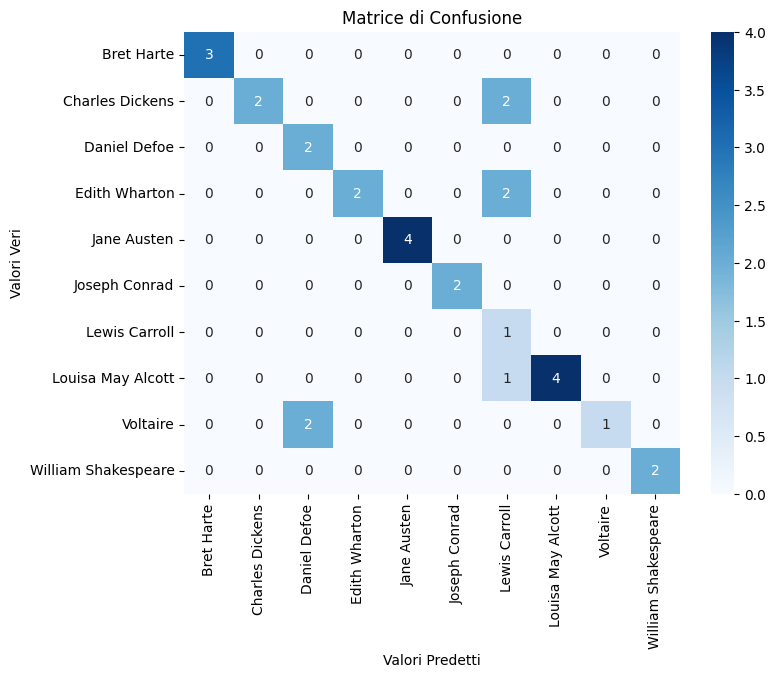

In [35]:
#Random Forest Classifier
accuracy_random_forest = classifier_function('RandomForest')

Accuracy score of Bayes : 0.9
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       0.50      1.00      0.67         2
           3       1.00      0.75      0.86         4
           4       1.00      1.00      1.00         4
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         5
           8       1.00      0.33      0.50         3
           9       1.00      1.00      1.00         2

    accuracy                           0.90        30
   macro avg       0.92      0.91      0.88        30
weighted avg       0.94      0.90      0.90        30


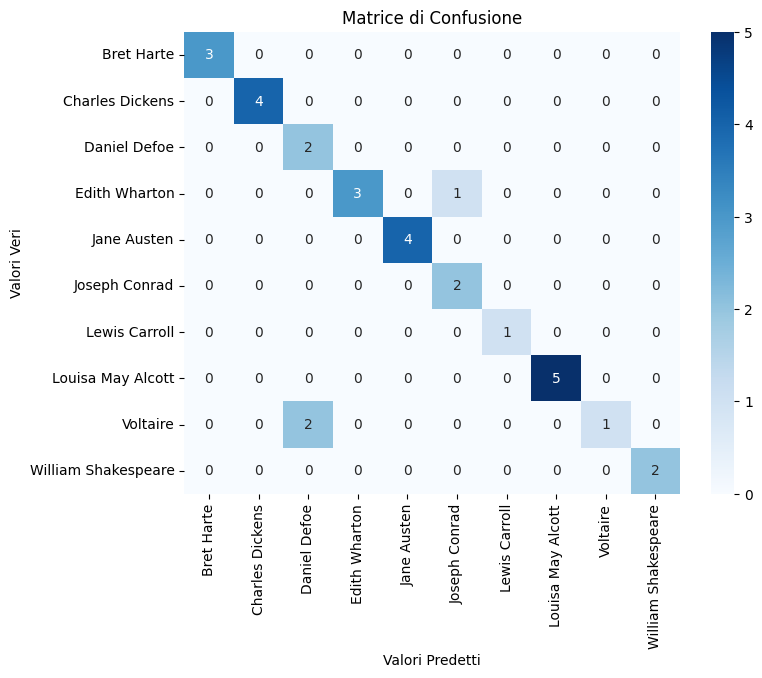

In [36]:
#Bayes Classifier
accuracy_bayes = classifier_function('Bayes')

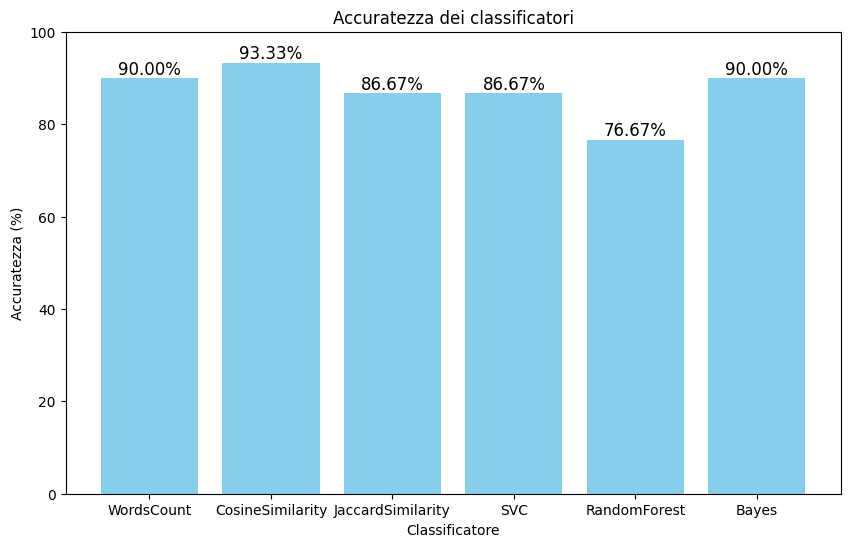

In [39]:
#Plot the bar chart of the ML classificators

list_classifiers = ["WordsCount","CosineSimilarity","JaccardSimilarity","SVC", "RandomForest", "Bayes"]
accuracies = [accuracy_wordsInCommon, accuracy_cosineSimilarity, accuracy_jaccardSimilarity, accuracy_svc, accuracy_random_forest, accuracy_bayes]
accuracies_percent = [acc * 100 for acc in accuracies]


plt.figure(figsize=(10,6))
bars = plt.bar(list_classifiers, accuracies_percent, color = 'skyblue')
plt.xlabel("Classificatore")
plt.ylabel('Accuratezza (%)')
plt.title("Accuratezza dei classificatori")
plt.ylim(0,100)

for bar, acc in zip(bars, accuracies_percent):
    plt.text(bar.get_x() + bar.get_width() / 2, acc, f'{acc:.2f}%', ha='center', va='bottom', fontsize=12)
plt.show()

# Other (Less accurate)

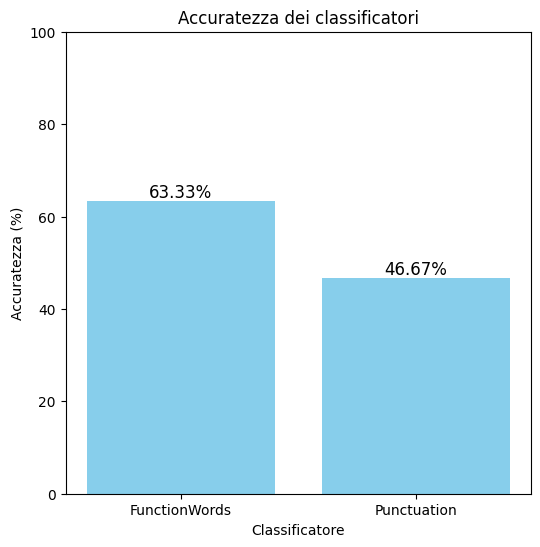

In [40]:
list_classifiers = ["FunctionWords","Punctuation"]
accuracies = [accuracy_functionWords, accuracy_punctuation]
accuracies_percent = [acc * 100 for acc in accuracies]

plt.figure(figsize=(6,6))
bars = plt.bar(list_classifiers, accuracies_percent, color = 'skyblue')
plt.xlabel("Classificatore")
plt.ylabel('Accuratezza (%)')
plt.title("Accuratezza dei classificatori")
plt.ylim(0,100)

for bar, acc in zip(bars, accuracies_percent):
    plt.text(bar.get_x() + bar.get_width() / 2, acc, f'{acc:.2f}%', ha='center', va='bottom', fontsize=12)
plt.show()